In [34]:
import numpy as np
import nerfax

from matplotlib import pyplot as plt
from bio_datasets.features.atom_array import load_structure
from bio_datasets.protein.internal_coordinates import get_backbone_internals, load_backbone_coord_array

%matplotlib inline

In [35]:
PDB_FILE = "../tests/AF-Q9R172-F1-model_v4.pdb"  # a long protein chain from AFDB

In [36]:
import numpy as np

def discretize_to_bits(arr: np.ndarray, bits: int, max_val: float, min_val: float = 0, signed: bool = False) -> np.ndarray:
    """
    Discretize a NumPy array of floats/integers to the specified number of bits with automatic scaling.
    
    Args:
        arr (np.ndarray): Array of floats or integers to be discretized.
        bits (int): Number of bits for discretization.
        min_val (float): Minimum possible value in the input range.
        max_val (float): Maximum possible value in the input range.
        signed (bool): Whether to use signed or unsigned integer representation.
    
    Returns:
        np.ndarray: Array of discretized integers.
    """
    if signed:
        # Signed range: [-2^(bits-1), 2^(bits-1) - 1]
        max_int_val = (2 ** (bits - 1)) - 1
        min_int_val = -(2 ** (bits - 1))
    else:
        # Unsigned range: [0, 2^bits - 1]
        max_int_val = (2 ** bits) - 1
        min_int_val = 0

    # Normalize to the range [0, 1]
    normalized = (arr - min_val) / (max_val - min_val)
    
    # Scale to the target integer range
    scaled = normalized * (max_int_val - min_int_val) + min_int_val
    
    # Discretize to integer values
    discretized = np.round(scaled).astype(np.int32)
    
    return discretized


def decode_from_bits(arr: np.ndarray, bits: int, max_val: float, min_val: float = 0, signed: bool = False) -> np.ndarray:
    """
    Decode a NumPy array of discretized integers back to the original floating-point values.
    
    Args:
        arr (np.ndarray): Array of discretized integers.
        bits (int): Number of bits used for discretization.
        min_val (float): Minimum possible value in the input range.
        max_val (float): Maximum possible value in the input range.
        signed (bool): Whether the original discretization used signed or unsigned integers.
    
    Returns:
        np.ndarray: Array of decoded floating-point values.
    """
    if signed:
        # Signed range: [-2^(bits-1), 2^(bits-1) - 1]
        max_int_val = (2 ** (bits - 1)) - 1
        min_int_val = -(2 ** (bits - 1))
    else:
        # Unsigned range: [0, 2^bits - 1]
        max_int_val = (2 ** bits) - 1
        min_int_val = 0

    # Scale back to the normalized range [0, 1]
    normalized = (arr - min_int_val) / (max_int_val - min_int_val)

    # Scale to the original value range [min_val, max_val]
    decoded = normalized * (max_val - min_val) + min_val
    
    return decoded


In [37]:
val = 1059.459
for i in range(1, 10):
    bit_conf = {"min_val": 0, "max_val": 2048, "signed": True, "bits": i}
    decoded = decode_from_bits(discretize_to_bits(np.array([val]), **bit_conf), **bit_conf)
    print(f"bits: {i}, input: {val}, decoded: {decoded[0]}")

bits: 1, input: 1059.459, decoded: 2048.0
bits: 2, input: 1059.459, decoded: 1365.3333333333333
bits: 3, input: 1059.459, decoded: 1170.2857142857142
bits: 4, input: 1059.459, decoded: 1092.2666666666667
bits: 5, input: 1059.459, decoded: 1057.032258064516
bits: 6, input: 1059.459, decoded: 1072.7619047619048
bits: 7, input: 1059.459, decoded: 1064.3149606299212
bits: 8, input: 1059.459, decoded: 1060.1411764705883
bits: 9, input: 1059.459, decoded: 1058.0665362035224


In [40]:
def load_coords(pdb_file: str, chain: str = "A"):
    """Load cartesian coordinates and internal coordinates for a protein backbone from a PDB file."""
    struct = load_structure(pdb_file)
    struct = struct[struct.chain_id == chain]
    xyz_bb = load_backbone_coord_array(struct)
    internals = get_backbone_internals(struct)
    return xyz_bb, internals

xyz_bb, internals = load_coords(PDB_FILE)


In [41]:
print("Cartesian coords shape:", xyz_bb.shape)
bond_lengths, bond_angles, dihedrals = internals
print("Internal coords shape:", bond_lengths.shape, bond_angles.shape, dihedrals.shape)


Cartesian coords shape: (2319, 3, 3)
Internal coords shape: (2319, 3) (2319, 3) (2319, 3)


N.B. the first entries in lengths and angles are weird outliers due to
adding a point at the origin as some kind of ghost first atom

In [42]:
bond_lengths[0].max(), bond_lengths[1:].max()  # outlier value in first row

(Array(74.48488, dtype=float32), Array(2.1124861, dtype=float32))

In [43]:
# idealised values
BACKBONE_BOND_LENGTHS = np.array([1.33,1.46,1.52])
BACKBONE_ANGLES = np.array([1.095, 0.98, 1.20])

Text(0.5, 1.0, 'Difference between actual bond angles and idealised values')

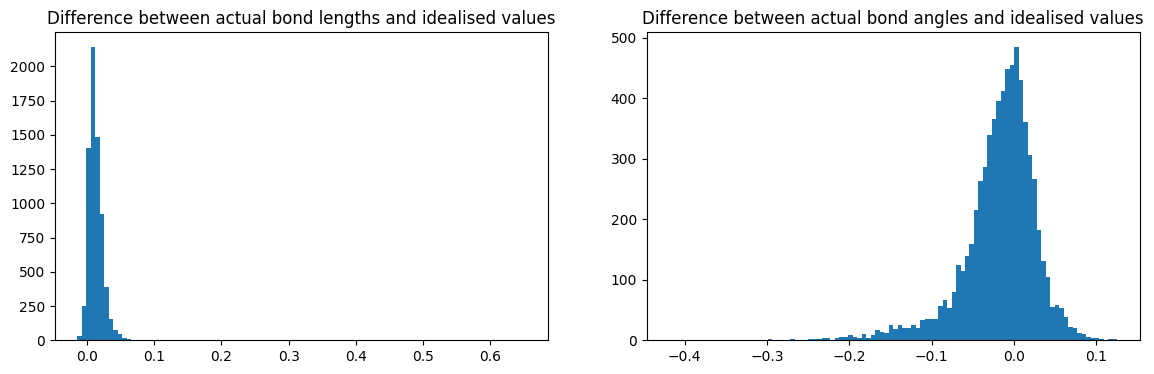

In [44]:
fig = plt.figure(figsize=(14, 4))
ax = plt.subplot(1, 2, 1)

length_diffs = bond_lengths - BACKBONE_BOND_LENGTHS
angle_diffs = bond_angles - BACKBONE_ANGLES

ax.hist(length_diffs[1:].reshape(-1), bins=100)
ax.set_title("Difference between actual bond lengths and idealised values", fontsize=12)


ax = plt.subplot(1, 2, 2)
ax.hist(angle_diffs[1:].reshape(-1), bins=100)
ax.set_title("Difference between actual bond angles and idealised values", fontsize=12)

In [47]:

class Compressor:
    def __init__(self, config: dict):
        self.config = config

    def compress(self, internal_coords):
        """Compress the internal coordinates. Return internal_coords tuple and compression config."""
        bond_lengths, bond_angles, dihedrals = internal_coords
        # YOUR CODE GOES HERE
        pass
    
    def decompress(self, compressed_internal_coords):
        """Decompress the internal coordinates. Return a tuple of the form (bond_lengths, bond_angles, dihedrals)"""
        # YOUR CODE GOES HERE
        pass


# WRITE ANY CONFIG FOR YOUR COMPRESSOR HERE
config = {}


def round_trip_rmsd(compressor=Compressor, config: dict = None):
    config = config or {}
    compressor = compressor(config)
    for pdb_file in ["../tests/AF-Q9R172-F1-model_v4.pdb", "../tests/AF-V9HVX0-F1-model_v4.pdb", "../tests/1qys.pdb", "../tests/1aq1.pdb"]:
        xyz_bb, internals = load_coords(pdb_file, chain="A")
        compressed_internals = compressor.compress(internals)
        decompressed_internals = compressor.decompress(compressed_internals)
        xyz_bb_reconstructed = nerfax.reconstruct.reconstruct_from_internal_coordinates(
            *decompressed_internals,
            mode='fully_sequential'
        )
        xyz_bb_reconstructed_aligned = nerfax.utils.get_align_rigid_bodies_fn(xyz_bb_reconstructed, xyz_bb.reshape((-1,3)))(xyz_bb_reconstructed)
        pdb_id = pdb_file.split("/")[-1].split(".")[0]
        print(f"RMSD {pdb_id} ({xyz_bb.shape[0]} residues) {nerfax.foldcomp_tests.compute_rmsd(xyz_bb_reconstructed_aligned, xyz_bb.reshape((-1,3))):.2f} Angstrom")



In [49]:
class NaiveCompressor(Compressor):
    def __init__(self, config: dict):
        """config for Naive Compressor: just min_val, max_val, signed, bits dicts for each internal coord.
        """
        super().__init__(config)

    def compress(self, internal_coords):
        """Compress the internal coordinates. Return internal_coords tuple and compression config."""
        bond_lengths, bond_angles, dihedrals = internal_coords
        length_config = self.config["lengths"]
        angle_config = self.config["angles"]
        dihedral_config = self.config["dihedrals"]
        return (
            discretize_to_bits(bond_lengths - BACKBONE_BOND_LENGTHS, **length_config),
            discretize_to_bits(bond_angles - BACKBONE_ANGLES, **angle_config),
            discretize_to_bits(dihedrals, **dihedral_config),
        )
    
    def decompress(self, compressed_internal_coords):
        """Decompress the internal coordinates. Return a tuple of the form (bond_lengths, bond_angles, dihedrals)"""
        # YOUR CODE GOES HERE
        return (
            decode_from_bits(compressed_internal_coords[0], **self.config["lengths"]) + BACKBONE_BOND_LENGTHS,
            decode_from_bits(compressed_internal_coords[1], **self.config["angles"]) + BACKBONE_ANGLES,
            decode_from_bits(compressed_internal_coords[2], **self.config["dihedrals"]),
        )

# 3* (6 + 12 + 14) = 96 bits = 12 bytes
twelve_byte_length_config = {"bits": 6, "signed": True, "min_val": -0.05, "max_val": 0.4}
twelve_byte_angle_config = {"bits": 12, "signed": False, "max_val": np.pi}
twelve_byte_torsion_config = {"bits": 14, "signed": False, "min_val": -np.pi, "max_val": np.pi}

round_trip_rmsd(NaiveCompressor, config={"lengths": twelve_byte_length_config, "angles": twelve_byte_angle_config, "dihedrals": twelve_byte_torsion_config})


RMSD AF-Q9R172-F1-model_v4 (2319 residues) 0.52 Angstrom
RMSD AF-V9HVX0-F1-model_v4 (61 residues) 0.02 Angstrom
RMSD 1qys (92 residues) 0.04 Angstrom
RMSD 1aq1 (277 residues) 0.10 Angstrom
